**Load packages**

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from umap import UMAP

**Exercise 2.1.1:** The performance of a random forest classifier is highly sensitive to hyper parameters.
Therefore, you should be intimately familiar with what the most important ones do. For each point below,
explain what the hyper parameter pertaining to sklearn.ensemble.RandomForestClassifier controls, and how
setting it either too low or too high (or True/False) might hurt model performance.

1) n_estimators: Number of trees in the forest. If the number is set too high, the model might overfit, i.e. remembering the training data
which leads to less accurate predictions out of sample.

2) max_depth: The max depth of the trees. If set to None, it will continue to expand until all leaves are pure, or until all leaves contain
less than min_samples_split samples. Can lead to overfitting.

3) max_features: Maximum number of features to include in each nodes split in the tree (when looking for the best split). If None
then equal to the number of features in the data set. If set to a high number, it might get computational heavy.

4) bootstrap: Whether bootstraping is used or not. If not then all samples are used in every tree. If False, then it might get computational heavy.


**Exercise 2.1.2:** For n_estimators > 1 how should one set the hyper-parameters max_features and bootstrap so that all the trees in the ensemble end up identical?

Set both to None. When max_features is None it uses n_features (all features). When bootstrap is None, it will use all observations in all trees.

**Exercise 3.1.2:** Reproduce the figure from the slides that compares PCA, LDA, t-SNE and UMAP as applied to the digits dataset.

In [2]:
# Get wine data
data_wine = load_wine()
X_wine = data_wine['data']
y_wine = data_wine['target']

# Get digits data
data_digits = load_digits()
X_digits = data_digits['data']
y_digits = data_digits['target']

1) Do it for the digits dataset

/Users/karlbindslev/.conda/envs/SDS_Econometrics_ML/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


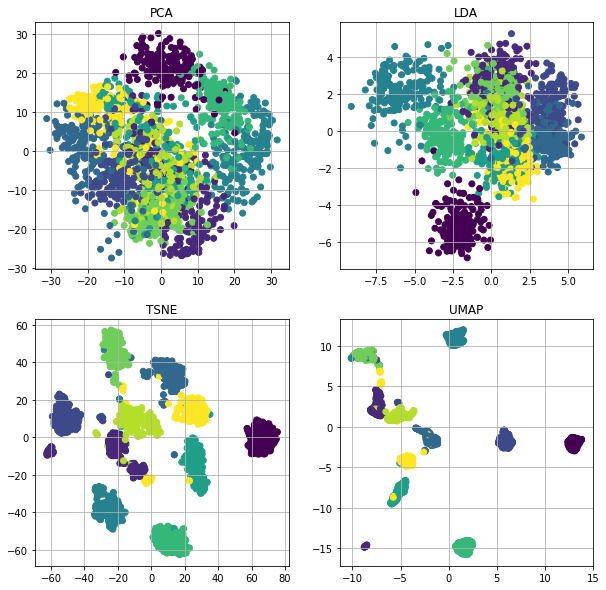

In [4]:
reducers = [PCA(), LDA(), TSNE(), UMAP()]
titles = ['PCA', 'LDA', 'TSNE', 'UMAP']

def fit_trans_plot(reducers, x, y, standardize=False):

    if standardize==True:
        x = StandardScaler().fit_transform(x)

    list_reducers = []
    for reducer in reducers:
        if reducer.__class__ == LDA:
            list_reducers.append(reducer.fit_transform(x,y))
        else:
            list_reducers.append(reducer.fit_transform(x))

    fig, axs = plt.subplots(2, 2, figsize = (10,10))
    axs[0, 0].scatter(list_reducers[0][:, 0], list_reducers[0][:, 1], c=y)
    axs[0, 0].set_title(titles[0])
    axs[0, 0].grid(True)
    axs[0, 1].scatter(list_reducers[1][:, 0], list_reducers[1][:, 1], c=y)
    axs[0, 1].set_title(titles[1])
    axs[0, 1].grid(True)
    axs[1, 0].scatter(list_reducers[2][:, 0], list_reducers[2][:, 1], c=y)
    axs[1, 0].set_title(titles[2])
    axs[1, 0].grid(True)
    axs[1, 1].scatter(list_reducers[3][:, 0], list_reducers[3][:, 1], c=y)
    axs[1, 1].set_title(titles[3])
    axs[1, 1].grid(True)

fit_trans_plot(reducers, X_digits, y_digits, standardize=False)

2) Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?

With standardized x:


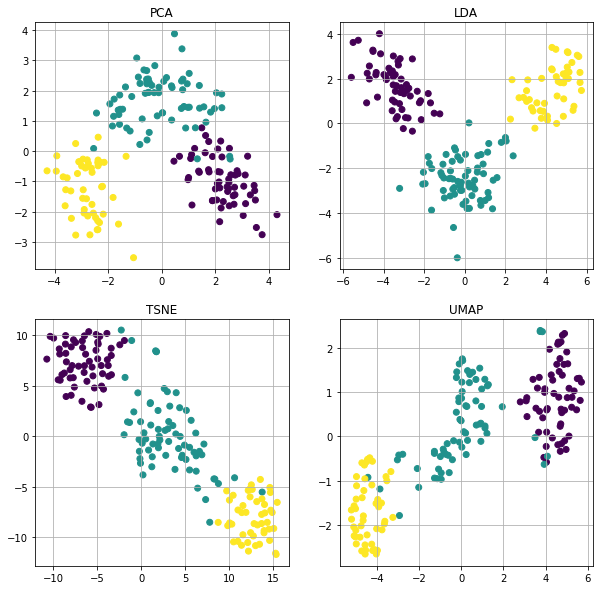

In [5]:
print("With standardized x:")
fit_trans_plot(reducers, X_wine, y_wine, standardize=True)

With non-standardized x:


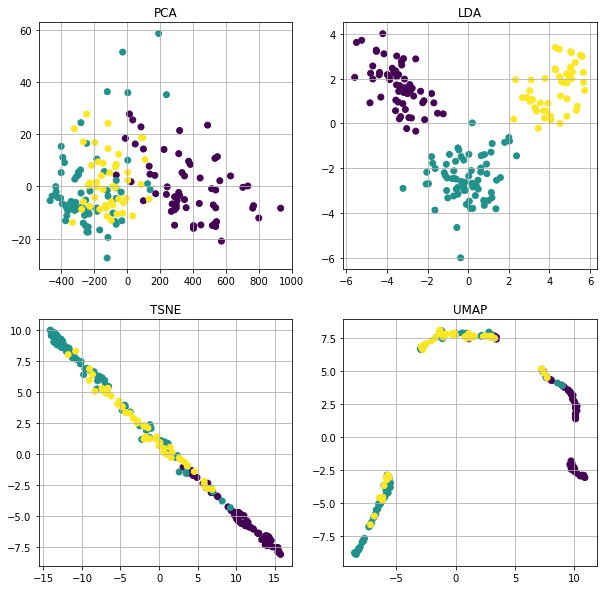

In [6]:
print("With non-standardized x:")
fit_trans_plot(reducers, X_wine, y_wine, standardize=False)

If we don't standardize, the data points are more mixed up and the axises (especially for PCA) explodes.
This is not a problem with the digits data, since all the features are measured in the same units (integers between 0 and 16).


3) Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.

TSNE and UMAP perform significantly better on the digits dataset compared to LDA and PCA. Moving to the wine dataset the conclusion is less straight forward, since all of the four methods seem to perform somewhat well in the case, where we standardize the data. In the case where we don't standardize the data, LDA seems to be the best reducer, since it actually manages to seperate the data into meaningful clusters, i.e. it has reduced the dimensionality in a meaningful way, so that the lower dimensioanl space still describes the variation in the data well. In general PCA performs poorly when the relationship between the variables is non-linear. TSNE on the other hand works well in non-linear cases. TSNE has the disadvantages, though, that it is loses interpretability. UMAP is quite similar to TSNE. 

**Exercise 4.2.1:** What does it mean that a tree is honest? In particular what are the implications in terms of

1) The intuition for why honesty is required in order to get good local treatment effect estimates?

When estimating treatment effects we run into the problem, that we can't actually observe the treatment effects.
Additionally, if using a "dis-honest" model, we can't do inference, which makes the estimation of treatment effects impossible.
In estimation using honest trees the training data is split into two parts - one for constructing the trees using cross-validation
and one for estimation of the treatment effects. It has been shown that this honesty can eliminate the bias, which allow us to do
inference. The downside is, that our sample is reduced (since we split it), resulting in loss of precision (higher MSE).

2) The practical implementation of the DT algorithm?

Splitting: The model recursively partitions the observations by maximizing -EMSE_tau, which is the negative adjusted MSE.
In this case the -EMSE_tau is the expected squared treatment effect minus the expected variance of the squared treatment effect.
Both of the components of the -EMSE_tau can be estimated using the training sample.

Cross-validation: In the cross-validation step the same -EMSE expression (as in the splitting process) is maximized but we
substitute the training sample with the cross-validation sample (which is a subset of the training sample?).
Thus partitions that find strong heterogeneity in treatment effects and create low variance in the estimates of the treatment
effect are preferred over the opposite.